# Fruit and Vegetable Prices


## Data set selection

> In this section, you will need to provide the following information about the selected data set:

### Source (with link) 
The dataset comes from the USDA Economic Research Service – Fruit and Vegetable Prices Database.  
Link: https://www.ers.usda.gov/data-products/fruit-and-vegetable-prices/

---

### Fields

- **`Fruit`** – Name of the fruit  
- **`Form`** – The form in which the fruit is sold (Fresh, Canned, Juice, Frozen, etc.)  
- **`RetailPrice`** – Price per unit as sold (e.g., per pound, per pint)  
- **`RetailPriceUnit`** – Unit of pricing  
- **`Yield`** – Edible yield percentage after removing waste (peel, core, etc.)  
- **`CupEquivalentSize`** – How much product is needed to make 1 edible cup  
- **`CupEquivalentUnit`** – Unit used for the cup conversion  
- **`CupEquivalentPrice`** – Cost to obtain one edible cup of the fruit  

---

### License
Creative Commons CCZero  
Link: http://www.opendefinition.org/licenses/cc-zero

### Data set selection rationale

I selected this dataset because this dataset could provide real-world economic and nutrition data that are useful for health insights. It includes multiple variables that I can use for statistical analysis. The dataset is clean overall, I didn't have to preprocess it. By analyzing this dataset, I might be able to create analysis related to fruit affordability, and which fruits bring most value based on its price and yield.

### Questions to be answered

> Using statistical analysis and visualization, what questions would you like to be able answer about this dataset.
> This could include questions such as:

 - What is the average retail price for different fresh fruits?  
 We can compare how fruit prices vary in cost
 - How does the form of the fruit affect the retail price?  
 This helps determine whether processing tends to make specific fruit more or less expensive
 - What is the relationship between retail price and cup equivalent price?  
 This helps understand how much edible fruit consumers actually get for the price they pay
 - How does yield impact the cost of edible fruit?
 This may answer if a fruit with low yield may be cheap per pound but be more expensive per serving
 - What are top 5 affordable fruits based on cup equivalent price?  
 This helps identify the most 5 affordable fruits. With the data collected, this would answer what fruits are the best for budget planning  
 - What is the distribution of fruit forms?
 This would answer which type of fruit products dominate the dataset. For stakeholders, it would help them understand what products consumers have access to.

### Visualization ideas

> Provide a few examples of what you plan to visualize to answer the questions you posed in the previous section. In this project, you will be producing 6-8 visualizations. You will also be producing an interactive chart using Plotly.
1. Interactive bar chart using Plotly for the average retail prices. This would show how fresh fruit prices vary across the dataset. By using Plotly, it would handle multiple labels of fruits on interacting with chart.  
2. Grouped bar chart for retail price vs form. This would show whether fresh or frozen tend to be cheaper or more expensive.  
3. Scatter plot for retail price vs cup equivalent price. This would help identify correlation between retail price and cup equivalent price so that stakeholders can what fruits bring the good value. I would use plotly for this chart because that way, it allows to label which help stakeholders see exact price values, make correlation patterns clearer.  
4. Interative scatter plot for the impact of yield on cup equivalent price. This would show how edible yield affects how much the consumers pay. Low-yield fruit may seem cheap per pound but expensive per cup.  
5. Bar chart for top 5 most affordable fruits. This would help identify the cheapest fruit based on cup equivalent price. This would be used for budget planning.  
6. Pie chart for distribution of fruit forms. This would help understand which types of fruit products dominate the dataset.



In [3]:
# 🚀 Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

try:
  import plotly.express as px
  import plotly.graph_objects as go
  PLOTLY_AVAILABLE = True
except ImportError:
  PLOTLY_AVAILABLE = False
  print("Note: Plotly not available. Interactive visualizations will be skipped.")

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 📊 Loading the Data
Load the fruit and vegetable prices dataset

In [4]:
# Load the fruit and vegetables dataset
df = pd.read_csv('data/Fruit-Prices-2022.csv')

# Display basic information about the dataset
print('Dataset Shape:', df.shape)

display(df.head())

Dataset Shape: (62, 8)


,Fruit,Form,RetailPrice,RetailPriceUnit,Yield,CupEquivalentSize,CupEquivalentUnit,CupEquivalentPrice
0,Apples,Fresh,1.8541,per pound,0.90,0.2425,pounds,0.4996
1,"Apples, applesauce",Canned,1.1705,per pound,1.00,0.5401,pounds,0.6323
2,"Apples, ready-to-drink",Juice,0.8699,per pint,1.00,8.0000,fluid ounces,0.4349
3,"Apples, frozen concentrate",Juice,0.6086,per pint,1.00,8.0000,fluid ounces,0.3043
4,Apricots,Fresh,3.6162,per pound,0.93,0.3638,pounds,1.4145


### Creating new column
I decide to create `CoreFruit` column that shows the core fruit of each record in `Fruit` column 

In [5]:
# Create Core Fruit column
df['CoreFruit'] = df['Fruit'].str.split(',').str[0].str.strip()

## 📊 Visualization Idea 1: Average Retail Price of Fresh Fruits

### 

In [4]:
# Retrieve retail price for fresh fruits
fresh_retail_price = df.loc[df['Form'] ==
                            'Fresh', ['Fruit', 'Form', 'RetailPrice']]

# Plotly for bar chart
fig = px.histogram(
    fresh_retail_price, x='Fruit', y='RetailPrice',
    histfunc='avg',
    title='Interactive Bar Chart: Average Retail Price of Fresh Fruits',
    labels={'RetailPrice': 'Retail Price'}
)
fig.show()

# 📊 Visualization Idea 2: Retail Price of Different Forms of Fruits (Blackberries, Blueberries, Cranberries, Strawberries)


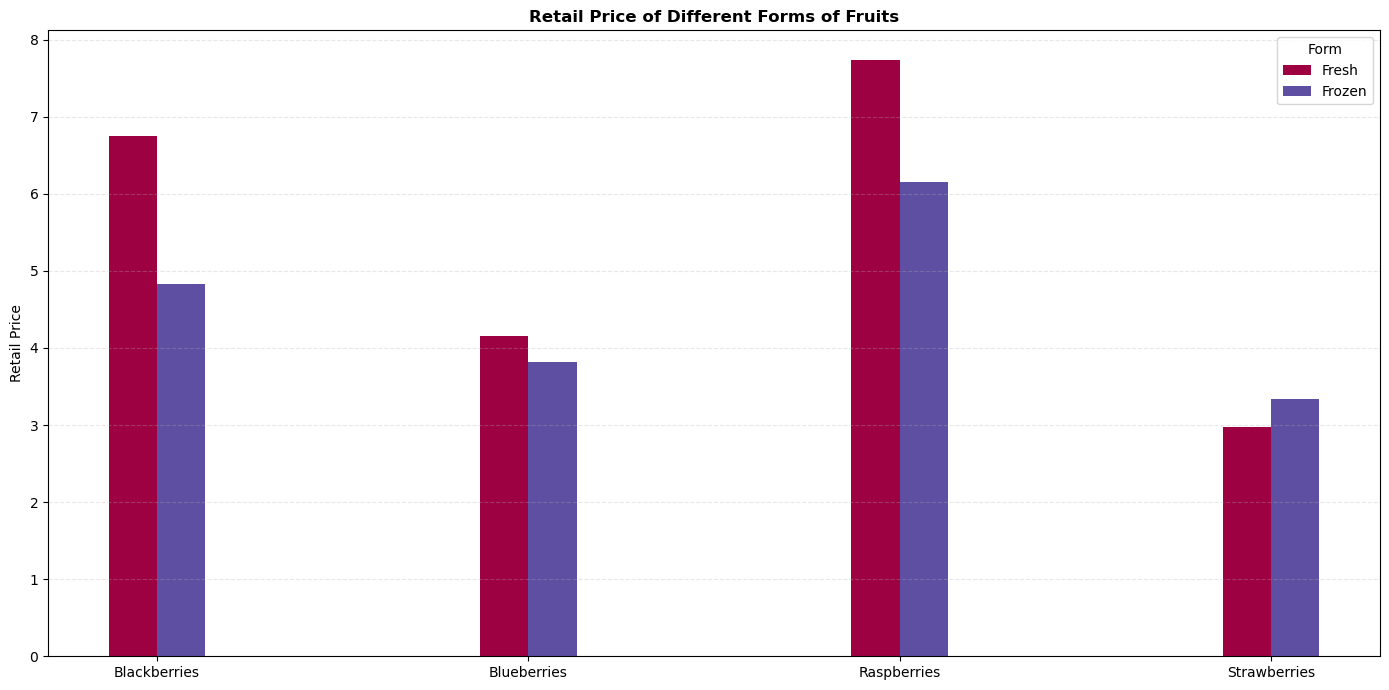

In [5]:
# Filter specific fruits from dataset
filter_mask = (df['CoreFruit'].str.contains('Blackberries', case=False)
               | df['CoreFruit'].str.contains('Blueberries', case=False)
               | df['CoreFruit'].str.contains('Raspberries', case=False)
               | df['CoreFruit'].str.contains('Strawberries', case=False))
selected_fruits_df = df[filter_mask]

# Pivot so each fruit x form shows its retail price
price_table = selected_fruits_df.pivot_table(
    index='CoreFruit',
    columns='Form',
    values='RetailPrice',
    aggfunc='mean'
)
x = np.arange(len(price_table.index))
bar_width = 0.13

fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title('Retail Price of Different Forms of Fruits', fontweight='bold')

cmap = plt.get_cmap('Spectral', len(price_table.columns))
for i, form in enumerate(price_table.columns):
  ax.bar(x+bar_width*i, price_table[form],
         width=bar_width, color=cmap(i), label=form)

ax.set_xticks(x + bar_width * (len(price_table.columns) - 1) / 2)
ax.set_xticklabels(price_table.index)

ax.set_ylabel("Retail Price")
ax.legend(title="Form")
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

## 📊 Visualization Idea 3: Retail Price vs Cup Equivalent Price


<Axes: xlabel='RetailPrice', ylabel='CupEquivalentPrice'>

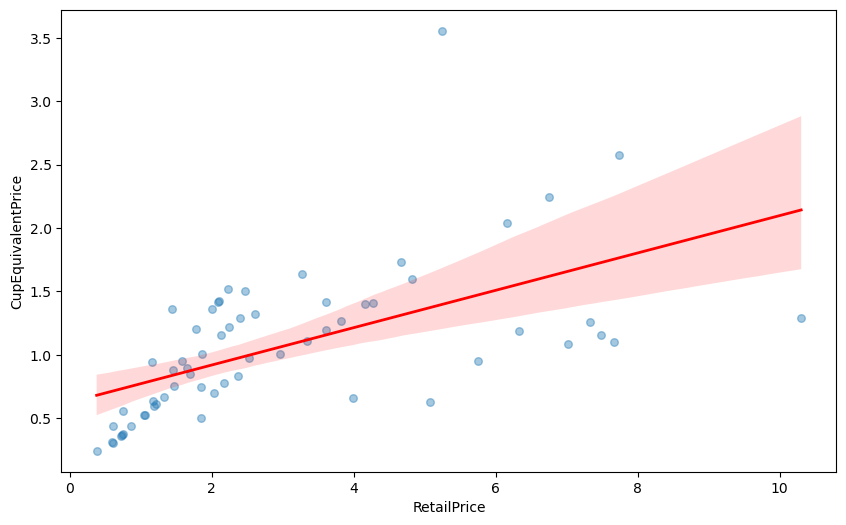

In [ ]:
retail_price = df['RetailPrice']
cup_price = df['CupEquivalentPrice']
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(data=df, x=retail_price, y=cup_price, ax=ax, scatter_kws={
            'alpha': 0.4, 's': 30}, line_kws={'color': 'red', 'linewidth': '2'})

In [ ]:
retail_price = df['RetailPrice']
cup_price = df['CupEquivalentPrice']
fig = px.scatter(df, x=retail_price, y=cup_price,
                 hover_data=['Fruit', 'Form',
                             'RetailPrice', 'CupEquivalentPrice', ''],
                 labels={'RetailPrice': 'Retail Price',
                         'CupEquivalentPrice': 'Cup Equivalent Price'},
                 title='Interactive Scatter Plot: Retail Price vs Cup Equivalent Price')
fig.update_layout(width=900, height=600)
fig.show()

## 📊 Visualization Idea 4: Yield vs Cup Equivalent Price 

In [17]:
fruit_yield = df['Yield']
cup_price = df['CupEquivalentPrice']
fig = px.scatter(df, x=fruit_yield, y=cup_price,
                 hover_data=['Fruit', 'Form',
                             'Yield', 'CupEquivalentPrice'],
                 labels={'CupEquivalentPrice': 'Cup Equivalent Price'},
                 title='Interactive Scatter Plot: Yield vs Cup Equivalent Price')
fig.update_layout(width=900, height=600)
fig.show()

## 📊 Visualization Idea 5: Top 5 Most Affordable Fruits


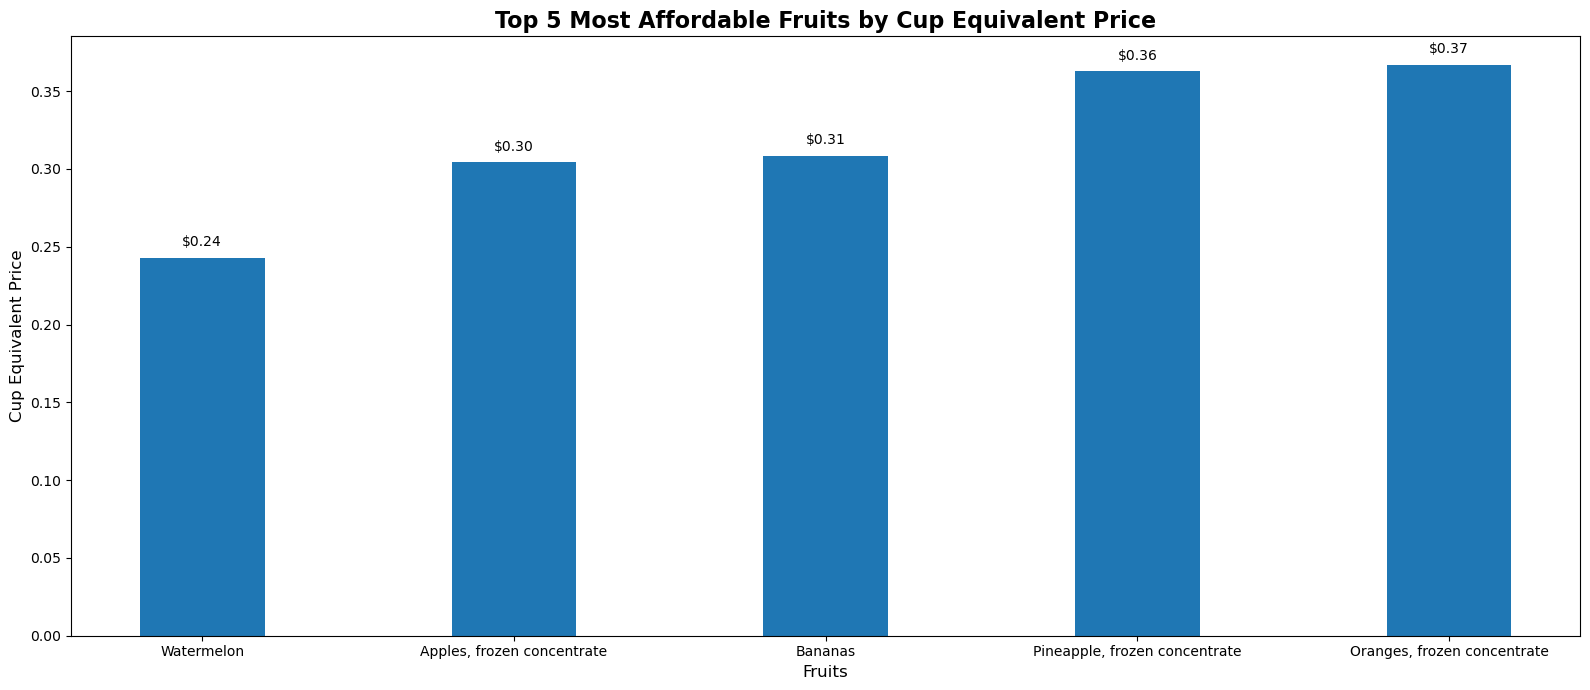

In [ ]:
data5 = df[['Fruit', 'CupEquivalentPrice']].sort_values('CupEquivalentPrice')
top5 = data5[:5]
x = np.arange(len(top5.index))

fig, ax = plt.subplots(figsize=(16, 7))
ax.bar(x=top5['Fruit'], width=bar_width, height=top5['CupEquivalentPrice'])
ax.set_title(
    'Top 5 Most Affordable Fruits by Cup Equivalent Price', fontsize=16, fontweight='bold')
ax.set_xlabel('Fruits', fontsize=12)
ax.set_ylabel('Cup Equivalent Price', fontsize=12)

for i, price in enumerate(top5['CupEquivalentPrice']):
  ax.text(i, price +
          0.01, f'${price:.2f}', va='center', ha='center')

plt.tight_layout()
plt.show()

## 📊 Visualization Idea 6: Average Retail Price of Fresh Fruits
